In [65]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [66]:
# Carregar datasets
dataset = pd.read_csv('dataset.csv')
features = pd.read_csv('just_features.csv')

In [67]:
# Função para tratamento de outliers usando IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [68]:
# Remover outliers nas variáveis 'custo' e 'imc'
dataset = remove_outliers(dataset, 'custo')
dataset = remove_outliers(dataset, 'imc')

In [69]:
# Separar features e target
X = dataset.drop(columns=['custo'])
y = dataset['custo']

In [70]:
# Identificar colunas categóricas e numéricas
categorical_features = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
numerical_features = ['imc']

In [71]:
# Configurar transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [72]:
# Criar o preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [75]:
# Grid de parâmetros refinado para Random Forest
param_grid_rf = {
    'regressor__n_estimators': [10,20,30,40,50,60,70,80,90,100],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [76]:
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=10, scoring='r2', verbose=2)


In [77]:
# Treinar Random Forest com GridSearch
print("Treinando Random Forest com ajuste fino...")
grid_search_rf.fit(X_train, y_train)

Treinando Random Forest com ajuste fino...
Fitting 10 folds for each of 270 candidates, totalling 2700 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV] END regressor__max_dept

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['imc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['genero',
                                                                          'estado_civil',
                                                                          'zona_residencia',
                                                                          'fumador',
                                                                          'class_etaria'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [10, 20, 30, 40, 50, 60, 70,
                                                     80, 90, 100]},
             scoring='r2', verbose=2)

In [78]:
# Melhor modelo Random Forest
best_rf = grid_search_rf.best_estimator_
print(f"Melhores hiperparâmetros RF: {grid_search_rf.best_params_}")

Melhores hiperparâmetros RF: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 70}


In [79]:
# Avaliação do modelo
y_pred_rf = best_rf.predict(X_test)
score_rf = r2_score(y_test, y_pred_rf)
print(f"R² Score com Random Forest: {score_rf:.4f}")

R² Score com Random Forest: 0.6707


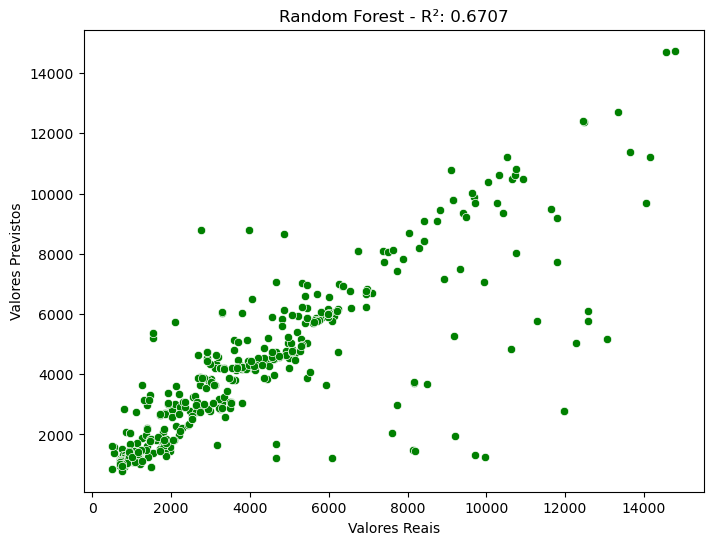

In [80]:
# Gráfico comparando valores reais e previstos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='green')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title(f"Random Forest - R²: {score_rf:.4f}")
plt.show()

In [81]:
# Previsão para novos dados (just_features.csv)
predictions = best_rf.predict(features)
predictions_df = pd.DataFrame(predictions, columns=['custo'])
predictions_df.to_csv('grupo#_custos_estimados.csv', index=False)
print("Predições salvas no arquivo 'grupo#_custos_estimados.csv'")

Predições salvas no arquivo 'grupo#_custos_estimados.csv'
